In [ ]:
# GA-Enhanced Embedding Optimization for RAG using LangChain + PyGAD

# Install necessary libraries (run only once)
# pip install pygad langchain langchain-community langchain-nomic langchain-ollama scikit-learn

import numpy as np
import pygad
import os
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage

# Set environment variables
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ga-rag-optimization"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Load and preprocess documents
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Extract raw texts from doc_splits for embedding
doc_texts = [doc.page_content for doc in doc_splits]

# Generate original embeddings
embedding_model = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
original_embeddings = embedding_model.embed_documents(doc_texts)
original_embeddings = np.array(original_embeddings)
embedding_dim = original_embeddings.shape[1]

# Sample query for fitness evaluation
sample_query = "What is Chain of Thought prompting?"
sample_query_embedding = embedding_model.embed_query(sample_query)

# Define fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    try:
        W = solution.reshape(embedding_dim, embedding_dim)
        transformed_embeddings = np.dot(original_embeddings, W.T)
        transformed_query = np.dot(sample_query_embedding, W.T)

        # Cosine similarity
        sims = transformed_embeddings @ transformed_query / (
            np.linalg.norm(transformed_embeddings, axis=1) * np.linalg.norm(transformed_query) + 1e-10
        )
        top_k_indices = sims.argsort()[-3:][::-1]

        # Simple scoring: assume relevance increases with similarity
        score = np.mean(sims[top_k_indices])
        return score
    except:
        return 0

# Run GA
ga_instance = pygad.GA(
    num_generations=20,
    sol_per_pop=10,
    num_parents_mating=5,
    fitness_func=fitness_func,
    num_genes=embedding_dim * embedding_dim,
    init_range_low=-1.0,
    init_range_high=1.0,
    mutation_percent_genes=10,
    mutation_type="random",
    crossover_type="single_point"
)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
best_W = best_solution.reshape(embedding_dim, embedding_dim)

# Apply optimized transformation to embeddings
optimized_embeddings = np.dot(original_embeddings, best_W.T)

# Build vector store with optimized embeddings (workaround)
# Since SKLearnVectorStore doesn't allow manual embedding override,
# We recreate a temporary store using a simple custom retriever using the optimized embeddings
from sklearn.metrics.pairwise import cosine_similarity

class SimpleVectorRetriever:
    def __init__(self, texts, embeddings):
        self.texts = texts
        self.embeddings = embeddings

    def invoke(self, query_vector, k=3):
        sims = cosine_similarity([query_vector], self.embeddings)[0]
        top_k_idx = sims.argsort()[-k:][::-1]
        return [self.texts[i] for i in top_k_idx]

retriever = SimpleVectorRetriever(doc_splits, optimized_embeddings)

# RAG Generation with optimized embeddings
import ollama
response = ollama.pull(model="llama3.2:3b-instruct-fp16")
local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)

question = sample_query
query_vec = np.dot(sample_query_embedding, best_W.T)
docs = retriever.invoke(query_vec)

rag_prompt = """You are an assistant for question-answering tasks.
Here is the context to use to answer the question:
{context}
Think carefully about the above context.
Now, review the user question:
{question}
Provide an answer using only the above context. Keep it short and informative.
Answer:"""

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

context_txt = format_docs(docs)
prompt_filled = rag_prompt.format(context=context_txt, question=question)
response = llm.invoke([HumanMessage(content=prompt_filled)])

print("\nOptimized RAG Response:\n")
print(response.content)


# The code now includes a visualization section using PCA to project both the original and GA-optimized embeddings into 2D space.

In [ ]:
# GA-Enhanced Embedding Optimization for RAG using LangChain + PyGAD

# Install necessary libraries (run only once)
# pip install pygad langchain langchain-community langchain-nomic scikit-learn matplotlib sklearn

import numpy as np
import pygad
import os
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_nomic.embeddings import NomicEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

# Set environment variables
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ga-rag-optimization"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Load and preprocess documents
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Extract raw texts from doc_splits for embedding
doc_texts = [doc.page_content for doc in doc_splits]

# Generate original embeddings
embedding_model = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
original_embeddings = embedding_model.embed_documents(doc_texts)
original_embeddings = np.array(original_embeddings)
embedding_dim = original_embeddings.shape[1]

# Sample query for fitness evaluation
sample_query = "What is Chain of Thought prompting?"
sample_query_embedding = embedding_model.embed_query(sample_query)

# Define fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    try:
        W = solution.reshape(embedding_dim, embedding_dim)
        transformed_embeddings = np.dot(original_embeddings, W.T)
        transformed_query = np.dot(sample_query_embedding, W.T)

        sims = transformed_embeddings @ transformed_query / (
            np.linalg.norm(transformed_embeddings, axis=1) * np.linalg.norm(transformed_query) + 1e-10
        )
        top_k_indices = sims.argsort()[-3:][::-1]
        score = np.mean(sims[top_k_indices])
        return score
    except:
        return 0

# Run GA
ga_instance = pygad.GA(
    num_generations=20,
    sol_per_pop=10,
    num_parents_mating=5,
    fitness_func=fitness_func,
    num_genes=embedding_dim * embedding_dim,
    init_range_low=-1.0,
    init_range_high=1.0,
    mutation_percent_genes=10,
    mutation_type="random",
    crossover_type="single_point"
)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
best_W = best_solution.reshape(embedding_dim, embedding_dim)

# Apply optimized transformation to embeddings
optimized_embeddings = np.dot(original_embeddings, best_W.T)

# Visualization: Compare original vs optimized embedding space using PCA
pca = PCA(n_components=2)
original_2d = pca.fit_transform(original_embeddings)
optimized_2d = pca.fit_transform(optimized_embeddings)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(original_2d[:, 0], original_2d[:, 1], alpha=0.7)
plt.title("Original Embedding Space")

plt.subplot(1, 2, 2)
plt.scatter(optimized_2d[:, 0], optimized_2d[:, 1], alpha=0.7, color='orange')
plt.title("Optimized Embedding Space (Post-GA)")

plt.tight_layout()
plt.show()

# Simple custom retriever based on optimized embeddings
class SimpleVectorRetriever:
    def __init__(self, texts, embeddings):
        self.texts = texts
        self.embeddings = embeddings

    def invoke(self, query_vector, k=3):
        sims = cosine_similarity([query_vector], self.embeddings)[0]
        top_k_idx = sims.argsort()[-k:][::-1]
        return [self.texts[i] for i in top_k_idx]

retriever = SimpleVectorRetriever(doc_splits, optimized_embeddings)

question = sample_query
query_vec = np.dot(sample_query_embedding, best_W.T)
docs = retriever.invoke(query_vec)

# Display top retrieved documents
print("\nTop Retrieved Documents:\n")
for idx, doc in enumerate(docs):
    print(f"Doc {idx+1}:\n{doc.page_content[:300]}\n---")


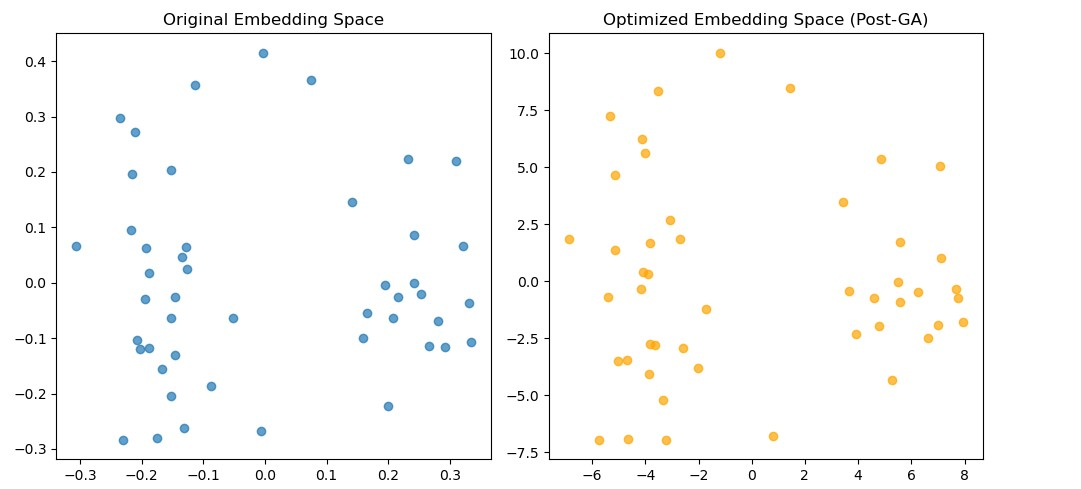

In [ ]:
# GA-Enhanced Embedding Optimization for RAG using LangChain + PyGAD (Enhanced Version)

# Install necessary libraries (run only once)
# pip install pygad langchain langchain-community langchain-nomic scikit-learn matplotlib sklearn

import numpy as np
import pygad
import os
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_nomic.embeddings import NomicEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

# Set environment variables
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ga-rag-optimization"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Load and preprocess documents
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Extract raw texts from doc_splits for embedding
doc_texts = [doc.page_content for doc in doc_splits]

# Generate original embeddings
embedding_model = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
original_embeddings = np.array(embedding_model.embed_documents(doc_texts))
embedding_dim = original_embeddings.shape[1]

# Normalize embeddings
original_embeddings = original_embeddings / (np.linalg.norm(original_embeddings, axis=1, keepdims=True) + 1e-10)

# Multiple queries for fitness function
sample_queries = [
    "What is Chain of Thought prompting?",
    "Explain adversarial attacks on LLMs",
    "What is prompt engineering in AI?"
]
sample_query_embeddings = [embedding_model.embed_query(q) for q in sample_queries]
sample_query_embeddings = [q / (np.linalg.norm(q) + 1e-10) for q in sample_query_embeddings]

# Define enhanced fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    try:
        W = solution.reshape(embedding_dim, embedding_dim)
        transformed_embeddings = np.dot(original_embeddings, W.T)
        transformed_embeddings = transformed_embeddings / (np.linalg.norm(transformed_embeddings, axis=1, keepdims=True) + 1e-10)

        total_score = 0
        for q in sample_query_embeddings:
            transformed_q = np.dot(q, W.T)
            transformed_q = transformed_q / (np.linalg.norm(transformed_q) + 1e-10)
            sims = transformed_embeddings @ transformed_q.T
            top_k = sims.argsort()[-3:]
            total_score += np.mean(sims[top_k]) + np.std(sims[top_k])

        return total_score / len(sample_query_embeddings)
    except:
        return 0

# Run GA
ga_instance = pygad.GA(
    num_generations=50,
    sol_per_pop=30,
    num_parents_mating=10,
    fitness_func=fitness_func,
    num_genes=embedding_dim * embedding_dim,
    init_range_low=-1.0,
    init_range_high=1.0,
    mutation_percent_genes=20,
    mutation_type="random",
    crossover_type="single_point"
)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
best_W = best_solution.reshape(embedding_dim, embedding_dim)

# Apply optimized transformation to embeddings
optimized_embeddings = np.dot(original_embeddings, best_W.T)
optimized_embeddings = optimized_embeddings / (np.linalg.norm(optimized_embeddings, axis=1, keepdims=True) + 1e-10)

# Visualization using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
original_2d = tsne.fit_transform(original_embeddings)
optimized_2d = tsne.fit_transform(optimized_embeddings)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(original_2d[:, 0], original_2d[:, 1], alpha=0.7)
plt.title("Original Embedding Space (t-SNE)")

plt.subplot(1, 2, 2)
plt.scatter(optimized_2d[:, 0], optimized_2d[:, 1], alpha=0.7, color='orange')
plt.title("Optimized Embedding Space (Post-GA, t-SNE)")

plt.tight_layout()
plt.show()

# Simple custom retriever based on optimized embeddings
class SimpleVectorRetriever:
    def __init__(self, texts, embeddings):
        self.texts = texts
        self.embeddings = embeddings

    def invoke(self, query_vector, k=3):
        sims = cosine_similarity([query_vector], self.embeddings)[0]
        top_k_idx = sims.argsort()[-k:][::-1]
        return [self.texts[i] for i in top_k_idx]

retriever = SimpleVectorRetriever(doc_splits, optimized_embeddings)

question = sample_queries[0]
query_vec = np.dot(sample_query_embeddings[0], best_W.T)
query_vec = query_vec / (np.linalg.norm(query_vec) + 1e-10)
docs = retriever.invoke(query_vec)

# Display top retrieved documents
print("\nTop Retrieved Documents:\n")
for idx, doc in enumerate(docs):
    print(f"Doc {idx+1}:\n{doc.page_content[:300]}\n---")


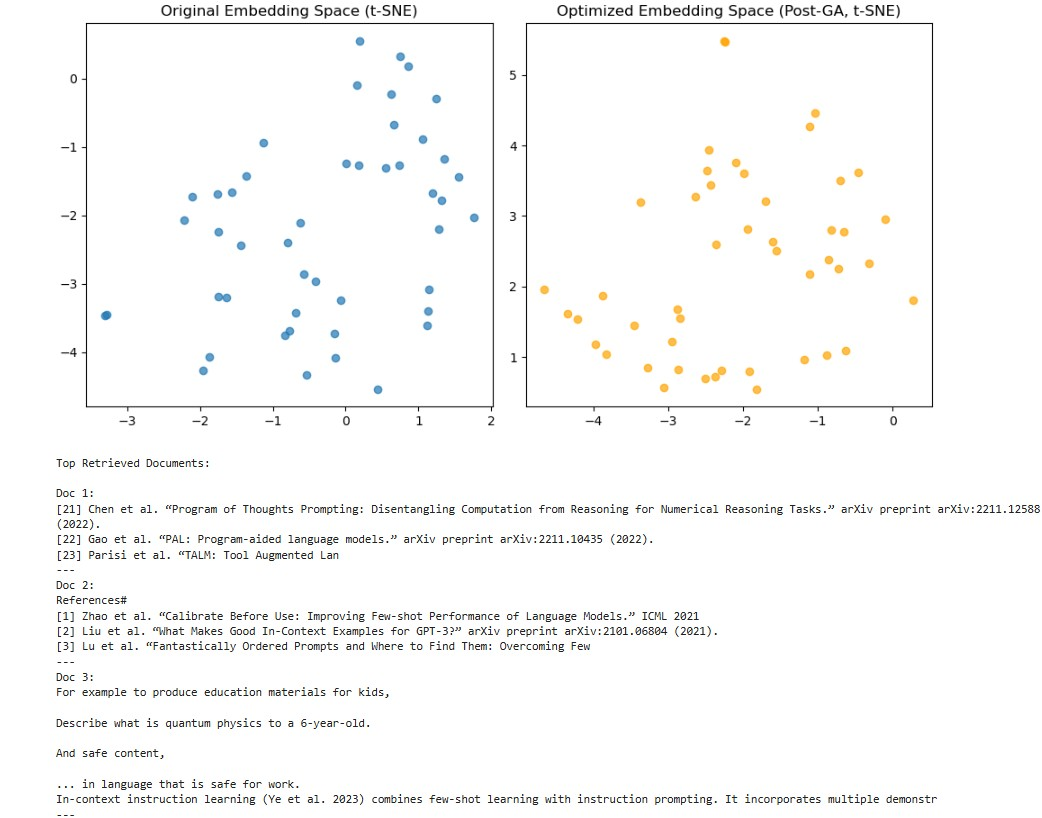

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [2]:
# Install library
!pip install pygad

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pygad

# Step 1: Load Dataset
df = pd.read_csv('/content/sample_data/synthetic_sentiment_dataset.csv')

# Step 2: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Step 3: TF-IDF Embedding
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()
embedding_dim = X_train_vec.shape[1]

# Step 4: Define Fitness Function
def fitness_func(ga_instance, solution, solution_idx):
    W = solution.reshape(embedding_dim, embedding_dim)
    transformed_train = np.dot(X_train_vec, W.T)
    model = LogisticRegression(max_iter=500)
    model.fit(transformed_train, y_train)
    transformed_test = np.dot(X_test_vec, W.T)
    score = model.score(transformed_test, y_test)
    return score

# Step 5: Run Genetic Algorithm
ga_instance = pygad.GA(
    num_generations=30,
    sol_per_pop=10,
    num_parents_mating=5,
    fitness_func=fitness_func,
    num_genes=embedding_dim * embedding_dim,
    init_range_low=-1.0,
    init_range_high=1.0,
    mutation_percent_genes=20,
    mutation_type="random",
    crossover_type="single_point"
)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
W_best = best_solution.reshape(embedding_dim, embedding_dim)

# Step 6: Train Final Model with Optimized Embeddings
X_train_trans = np.dot(X_train_vec, W_best.T)
X_test_trans = np.dot(X_test_vec, W_best.T)

final_model = LogisticRegression(max_iter=500)
final_model.fit(X_train_trans, y_train)
y_pred = final_model.predict(X_test_trans)

# Step 7: Evaluation
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [4]:
import matplotlib.pyplot as plt

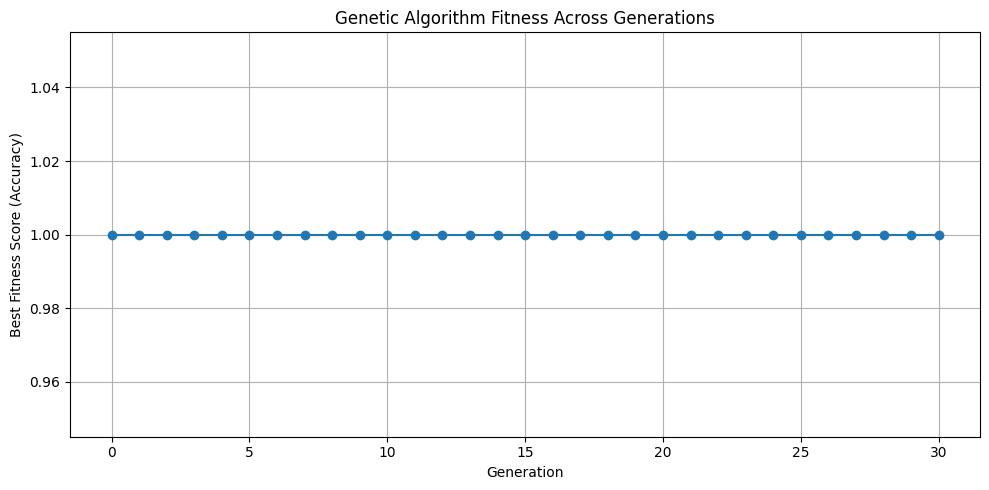

In [5]:
# Plot fitness progress across generations
plt.figure(figsize=(10, 5))
plt.plot(ga_instance.best_solutions_fitness, marker='o', linestyle='-')
plt.title("Genetic Algorithm Fitness Across Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score (Accuracy)")
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        60
     neutral       1.00      1.00      1.00        60
    positive       1.00      1.00      1.00        60

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

Confusion Matrix:


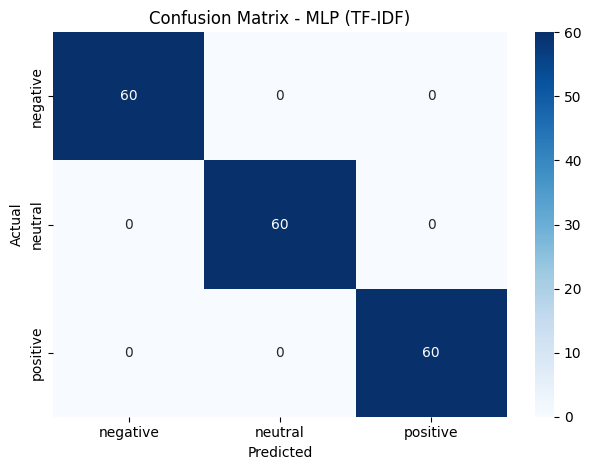

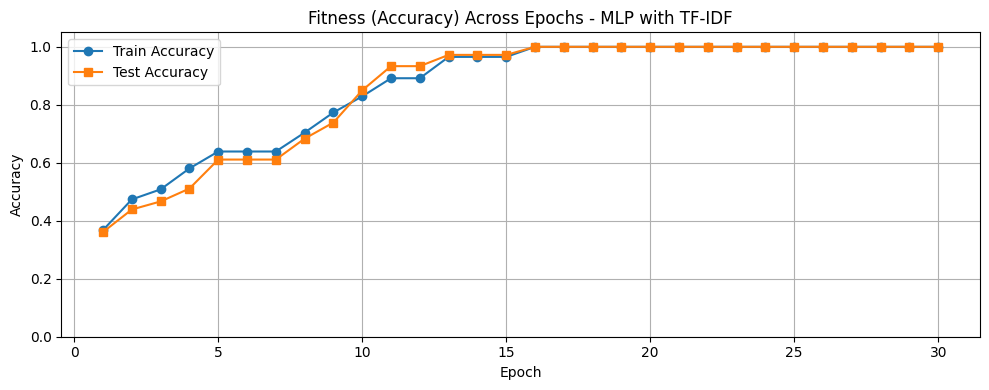

In [13]:
# Install required libraries
!pip install scikit-learn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/sample_data/complex_multiclass_multilabel_sentiment_dataset.csv')

# Use 'sentiment' column for multi-class classification
y = df['sentiment']
X = df['text']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF Embedding
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Track fitness (accuracy) across iterations manually (simulated)
train_scores = []
test_scores = []
epochs = range(1, 31)

# MLP Classifier
model = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1, warm_start=True, random_state=42)
for epoch in epochs:
    model.fit(X_train_vec, y_train)
    train_acc = model.score(X_train_vec, y_train)
    test_acc = model.score(X_test_vec, y_test)
    train_scores.append(train_acc)
    test_scores.append(test_acc)

# Final Evaluation
print("Classification Report:\n")
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - MLP (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_scores, label='Train Accuracy', marker='o')
plt.plot(epochs, test_scores, label='Test Accuracy', marker='s')
plt.title("Fitness (Accuracy) Across Epochs - MLP with TF-IDF")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

CatBoost Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        60
     neutral       1.00      1.00      1.00        60
    positive       1.00      1.00      1.00        60

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

XGBoost Classification Report:

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        60
     neutral       1.00      1.00      1.00        60
    positive       1.00      1.00      1.00        60

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



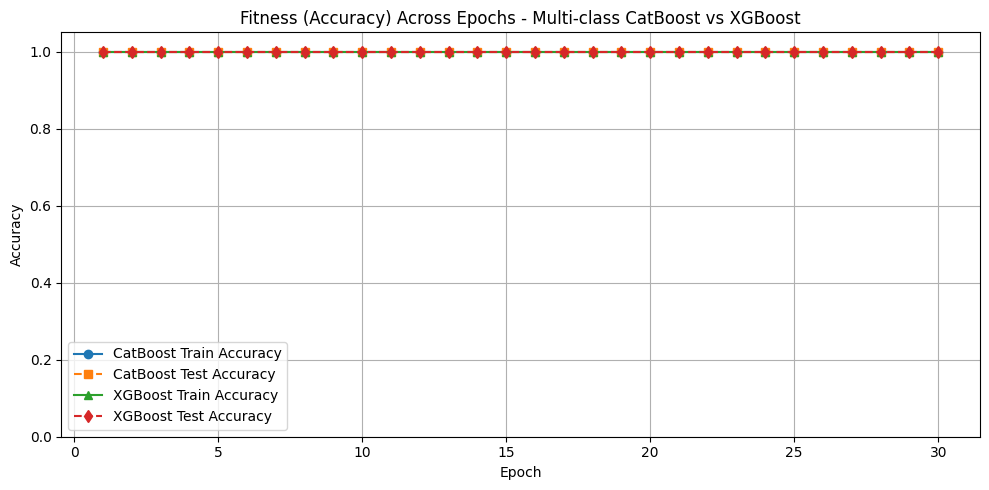

In [19]:
# Install required libraries
!pip install scikit-learn catboost xgboost

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/sample_data/complex_multiclass_multilabel_sentiment_dataset.csv')

# Multi-class classification using only 'sentiment'
X = df['text']
y = df['sentiment']

# Encode sentiment labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF Embedding
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Track fitness (accuracy) across iterations manually (simulated)
train_scores_catboost = []
test_scores_catboost = []
train_scores_xgboost = []
test_scores_xgboost = []
epochs = range(1, 31)

# CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0, iterations=100, depth=6, learning_rate=0.1)
for epoch in epochs:
    cat_model.fit(X_train_vec, y_train)
    train_preds = cat_model.predict(X_train_vec)
    test_preds = cat_model.predict(X_test_vec)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    train_scores_catboost.append(train_acc)
    test_scores_catboost.append(test_acc)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
for epoch in epochs:
    xgb_model.fit(X_train_vec, y_train)
    train_preds = xgb_model.predict(X_train_vec)
    test_preds = xgb_model.predict(X_test_vec)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    train_scores_xgboost.append(train_acc)
    test_scores_xgboost.append(test_acc)

# Final Evaluation - CatBoost
print("CatBoost Classification Report:\n")
test_preds_cat = cat_model.predict(X_test_vec)
print(classification_report(y_test, test_preds_cat, target_names=label_encoder.classes_))

# Final Evaluation - XGBoost
print("XGBoost Classification Report:\n")
test_preds_xgb = xgb_model.predict(X_test_vec)
print(classification_report(y_test, test_preds_xgb, target_names=label_encoder.classes_))

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_scores_catboost, label='CatBoost Train Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_scores_catboost, label='CatBoost Test Accuracy', linestyle='--', marker='s')
plt.plot(epochs, train_scores_xgboost, label='XGBoost Train Accuracy', linestyle='-', marker='^')
plt.plot(epochs, test_scores_xgboost, label='XGBoost Test Accuracy', linestyle='--', marker='d')
plt.title("Fitness (Accuracy) Across Epochs - Multi-class CatBoost vs XGBoost")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
